In [60]:
import pandas as pd
import os
from os.path import join

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from src.pr_model import P_R_Network
from src.ps_model import P_S_Network, p_s_loss

In [135]:
class CPR:
    def __init__(self, pr_model, ps_model, n_items):
        self.pr_model = pr_model
        self.Q = pr_model.item_emb.weight.data
        self.wR = pr_model.w.data.squeeze()
        
        self.ps_model = ps_model
        self.n_items = n_items
    
    def sample_alpha_posterior(self):
        return torch.randn(self.n_items)
    
    def sample_beta_posterior(self, k):
        return torch.randn(k)
    
    def gen_r_from_tau(self, tau, k):
        """
        tau: action center - torch.tensor(1, emb_dim)
        k: number of items - int
        """
        alpha = self.sample_alpha_posterior()
        score = (tau @ self.Q.T) + (self.wR * alpha)
        scores_dict = dict(enumerate(score.data.squeeze()))
        sorted_dict = dict(sorted(scores_dict.items(), key=lambda item:item[1], reverse=True))
        return list(sorted_dict.keys())[:k]
    
    def gen_s(self, u, r, M):
        """
        u: user id - int
        r: list of item ids - [int]
        M - itens to be selected - int
        """
        beta = self.sample_beta_posterior(len(r))
        
        u_b = torch.LongTensor([[u]])
        r_b = torch.LongTensor([r])
        r_mask_b = torch.ones(1, len(r))
        beta_b = beta.unsqueeze(0)
        score = self.ps_model(u_b, r_b, r_mask_b, None, beta_b).data[0]
        
        scores_dict = dict(zip(r, score))
        sorted_dict = dict(sorted(scores_dict.items(), key=lambda item:item[1], reverse=True))
        return list(sorted_dict.keys())[:M]
    
    def gen_s_score(self, u, r):
        """
        u: user id - int
        r: list of item ids - [int]
        M - itens to be selected - int
        """
        beta = self.sample_beta_posterior(len(r))
        
        u_b = torch.LongTensor([[u]])
        r_b = torch.LongTensor([r])
        r_mask_b = torch.ones(1, len(r))
        beta_b = beta.unsqueeze(0)
        score = self.ps_model(u_b, r_b, r_mask_b, None, beta_b).data[0]
        
        scores_dict = dict(zip(r, score))
        sorted_dict = dict(sorted(scores_dict.items(), key=lambda item:item[1], reverse=True))
        return sorted_dict

In [2]:
data_path = 'MIND-small_pp'
user_df = pd.read_csv(join(data_path, 'user_d.csv'))
user_d = {code: ind for code, ind in zip(user_df['code'], user_df['indice'])}
item_df = pd.read_csv(join(data_path, 'item_d.csv'))
item_d = {code: ind for code, ind in zip(item_df['code'], item_df['indice'])}

inv_user_d = {v:k for k,v in user_d.items()}
inv_item_d = {v:k for k,v in item_d.items()}

In [5]:
pr_model = P_R_Network(len(user_d)+1, len(item_d)+1)
pr_model.load_state_dict(torch.load('pr_model_60epochs/pr_model.pth'))

<All keys matched successfully>

In [6]:
ps_model = P_S_Network(len(user_d)+1, len(item_d)+1, 299)
ps_model.load_state_dict(torch.load('ps_model_100epochs/ps_model.pth'))

<All keys matched successfully>

In [11]:
train_df = pd.read_csv(join(data_path, 'train_df.csv'))
val_df = pd.read_csv(join(data_path, 'val_df.csv'))

In [136]:
cpr = CPR(pr_model, ps_model, len(item_d)+1)

# Entendendo P_S

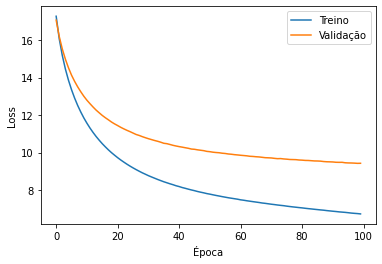

In [38]:
ps_model_loss = pd.read_csv('ps_model_100epochs/ps_loss.csv')
aux_df = pd.DataFrame(index=ps_model_loss.index)
aux_df['Época'] = ps_model_loss['epoch']
aux_df['Treino'] = ps_model_loss['train']
aux_df['Validação'] = ps_model_loss['val']
aux_df = aux_df.set_index('Época')
ax = sns.lineplot(data=aux_df, dashes=False)
ax.set(xlabel='Época', ylabel='Loss')
plt.show()

In [114]:
def get_rank_s(s, pred_s_rank):
    ind_l = []
    for i_s in s:
        for i, i_pred_s in enumerate(pred_s_rank):
            if i_s == i_pred_s:
                ind_l.append(i)
    return ind_l

def get_hr_s(s, pred_s_rank, K):
    hits = 0
    for i_s in s:
        if i_s in pred_s_rank[:K]:
            hits+=1
    return hits / len(s)

In [126]:
# Emb 32
int_df = val_df

agg_s_ids = []
agg_hr = []

for row in int_df.iterrows():
    row = row[1]
    u = user_d[row['UserID']]
    r = [item_d[it] for it in row['R'].split()]
    s = [item_d[it] for it in row['S'].split()]
    M = len(r)
    pred_s = cpr.gen_s(u, r, M)
    agg_s_ids+= get_rank_s(s, pred_s)
    agg_hr.append(get_hr_s(s, pred_s, len(s)))
    
print('Hit ratio = ', pd.Series(agg_hr).mean())

Hit ratio =  0.1219518693276408


<AxesSubplot:ylabel='Frequency'>

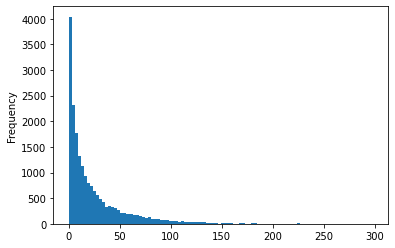

In [130]:
pd.Series(agg_s_ids).plot.hist(bins=100)

In [131]:
int_df = train_df

agg_s_ids = []
agg_hr = []

for row in int_df.iterrows():
    row = row[1]
    u = user_d[row['UserID']]
    r = [item_d[it] for it in row['R'].split()]
    s = [item_d[it] for it in row['S'].split()]
    M = len(r)
    pred_s = cpr.gen_s(u, r, M)
    agg_s_ids+= get_rank_s(s, pred_s)
    agg_hr.append(get_hr_s(s, pred_s, len(s)))
    
print('Hit ratio = ', pd.Series(agg_hr).mean())

Hit ratio =  0.23908076270632406


In [156]:

ps_model_2 = P_S_Network(len(user_d)+1, len(item_d)+1, 299, emb_dim=8)
ps_model_2.load_state_dict(torch.load('ps_model.pth'))

cpr_2 = CPR(pr_model, ps_model_2, len(item_d)+1)

In [158]:
# Emb = 8

int_df = val_df

agg_s_ids = []
agg_hr = []

for row in int_df.iterrows():
    row = row[1]
    u = user_d[row['UserID']]
    r = [item_d[it] for it in row['R'].split()]
    s = [item_d[it] for it in row['S'].split()]
    M = len(r)
    pred_s = cpr_2.gen_s(u, r, M)
    agg_s_ids+= get_rank_s(s, pred_s)
    agg_hr.append(get_hr_s(s, pred_s, len(s)))
    
print('Hit ratio = ', pd.Series(agg_hr).mean())

Hit ratio =  0.1659999183174819


In [159]:

ps_model_2 = P_S_Network(len(user_d)+1, len(item_d)+1, 299, emb_dim=2)
ps_model_2.load_state_dict(torch.load('ps_model.pth'))

cpr_2 = CPR(pr_model, ps_model_2, len(item_d)+1)

int_df = val_df

agg_s_ids = []
agg_hr = []

for row in int_df.iterrows():
    row = row[1]
    u = user_d[row['UserID']]
    r = [item_d[it] for it in row['R'].split()]
    s = [item_d[it] for it in row['S'].split()]
    M = len(r)
    pred_s = cpr_2.gen_s(u, r, M)
    agg_s_ids+= get_rank_s(s, pred_s)
    agg_hr.append(get_hr_s(s, pred_s, len(s)))
    
print('Hit ratio = ', pd.Series(agg_hr).mean())

Hit ratio =  0.1704201315391642


In [ ]:
# Hit ratio esta muito baixo

# Entendendo P_R

Hit ratio?
Ranking?

Calcular o score 

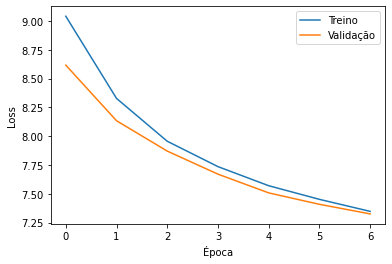

In [179]:
pr_model_loss = pd.read_csv('pr_loss.csv')
aux_df = pd.DataFrame(index=pr_model_loss.index)
aux_df['Época'] = pr_model_loss['epoch']
aux_df['Treino'] = pr_model_loss['train']
aux_df['Validação'] = pr_model_loss['val']
aux_df = aux_df.set_index('Época')
ax = sns.lineplot(data=aux_df, dashes=False)
ax.set(xlabel='Época', ylabel='Loss')
plt.show()

In [170]:
pr_model = P_R_Network(len(user_d)+1, len(item_d)+1, emb_dim=2)
pr_model.load_state_dict(torch.load('pr_model.pth'))

<All keys matched successfully>

In [172]:
cpr = CPR(pr_model, ps_model, len(item_d)+1)

In [173]:
u_emb = pr_model.user_emb.weight.data[1]
u_emb.size()

torch.Size([2])

In [174]:
tau = u_emb
alpha = cpr.sample_alpha_posterior()
score = (tau @ cpr.Q.T) + (cpr.wR * alpha)

In [175]:
cpr.gen_r_from_tau(u_emb, len(item_d)+1)

[7689,
 14097,
 2441,
 17145,
 11281,
 384,
 11040,
 3151,
 7804,
 9029,
 6696,
 12614,
 9740,
 19664,
 19561,
 8228,
 12007,
 2611,
 13964,
 16640,
 6758,
 9356,
 9667,
 15214,
 7240,
 501,
 4584,
 3595,
 4408,
 16588,
 14024,
 8044,
 4543,
 13642,
 919,
 14055,
 14488,
 2208,
 17833,
 4748,
 2854,
 5005,
 13237,
 16179,
 13640,
 12006,
 5150,
 7781,
 16237,
 6689,
 6470,
 17789,
 3135,
 14033,
 1150,
 8754,
 4622,
 12814,
 14677,
 116,
 7940,
 3263,
 292,
 15134,
 9675,
 7406,
 11274,
 5423,
 9683,
 563,
 12718,
 18057,
 12514,
 11590,
 10754,
 3319,
 538,
 12725,
 5562,
 17069,
 11788,
 14009,
 14482,
 18635,
 3272,
 9182,
 4901,
 18386,
 3565,
 3395,
 14720,
 6446,
 4478,
 1786,
 6927,
 16271,
 13221,
 7412,
 4096,
 6435,
 3944,
 1072,
 11595,
 6080,
 3213,
 4021,
 558,
 11360,
 18764,
 12290,
 3457,
 8931,
 1568,
 963,
 18133,
 5273,
 5751,
 16329,
 8467,
 9011,
 12066,
 19589,
 9579,
 12698,
 776,
 11382,
 14643,
 16108,
 4776,
 8525,
 4885,
 8558,
 14799,
 1449,
 12166,
 13357,


In [183]:
import math
math.exp(-0.4)

0.6703200460356393

In [133]:
train_rec_by_u = train_df.groupby('UserID').apply(lambda x: (" ".join(x['R']).split()))

In [169]:
[item_d[i] for i in train_rec_by_u.loc[inv_user_d[1]]]

[721, 1032]

In [152]:
item_d['N15960']

10777

In [ ]:
pr_model()

In [100]:
i = 2
u = user_d[val_df.iloc[i]['UserID']]
r = [item_d[it] for it in val_df.iloc[i]['R'].split()]
s = [item_d[it] for it in val_df.iloc[i]['S'].split()]
M = len(r)

In [101]:
pred_s = cpr.gen_s(u, r, M)
print(pred_s)
print([inv_item_d[ss] for ss in pred_s])

[2796, 3948, 17014, 10320, 14449, 18917, 17297, 12984, 16737, 5747, 10723, 2235, 7265, 4058, 10379, 11791, 18550, 17047, 18342, 6459, 6344, 1914, 2013, 15345, 11508, 12676, 18330, 8529, 18214, 1956, 4962, 12452, 8823, 1083, 12932, 15800, 5814, 6952]
['N59009', 'N38294', 'N60539', 'N53031', 'N4105', 'N63913', 'N55322', 'N6645', 'N32015', 'N16118', 'N14273', 'N22975', 'N54752', 'N29490', 'N37142', 'N37204', 'N14285', 'N12446', 'N11784', 'N61740', 'N22257', 'N28861', 'N6471', 'N62894', 'N19050', 'N20270', 'N58345', 'N48707', 'N55712', 'N57081', 'N9621', 'N51133', 'N26125', 'N61233', 'N41934', 'N34668', 'N6477', 'N36288']


In [103]:
get_rank_s(s, pred_s)

[12]

In [89]:
score_d = cpr.gen_s_score(u, r)

In [94]:
score_d[17788]

tensor(3.0657)

<AxesSubplot:ylabel='Frequency'>

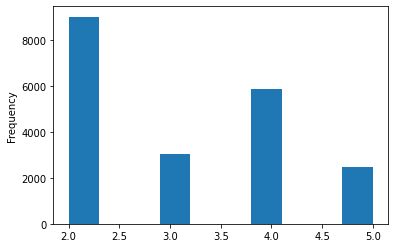

In [155]:
tst_s = train_df['R'].apply(lambda x: len(x.split(' ')))
tst_s[tst_s <= 5].plot.hist()

In [153]:
""train_df['R']

,UserID,R,S
0,U41705,N27437 N35847 N53470 N43670 N4754 N6857 N15719...,N26224
1,U62382,N732 N58051 N5889 N27845 N52000 N18870 N5957 N...,N24272
2,U57046,N27601 N54125 N19092 N4247 N33677 N18887 N8400...,N3344 N64851
3,U48904,N14029 N51048 N37437 N64252 N4642 N42457 N51287,N14029
4,U28525,N51398 N37108 N41178 N58075 N5442 N52345 N5889...,N62070
...,...,...,...
134199,U50951,N42698 N11784 N14285 N22975 N2960 N48487 N5286...,N2960 N41934
134200,U71950,N33501 N53861 N33831 N53470 N51048 N62920 N157...,N36186
134201,U19554,N30518 N23129 N54489 N42597 N46526 N23081 N169...,N23081
134202,U3500,N50314 N42634 N32544 N6056 N36786 N28413 N6397...,N24111


In [ ]:
train_df['R'].apply(lambda x)